In [63]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

### Load image and convert to grayscale

In [609]:
img = cv2.imread('IMG_3556.PNG')

In [610]:
# Dimensions of image
img.shape

(765, 1200, 3)

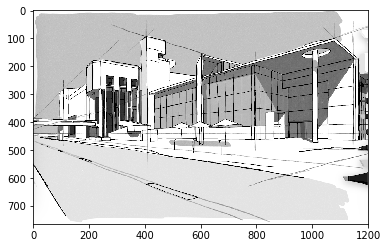

In [611]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_ = plt.imshow(gray, cmap='gray')

### Gaussian blur

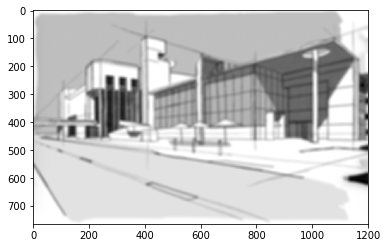

In [612]:
kernel_size = (19, 19)
sigma = 5
blurred = cv2.GaussianBlur(gray, kernel_size, sigma)
_ = plt.imshow(blurred, cmap='gray')

### Detect edges using Canny

In [640]:
edges = cv2.Canny(gray, 60, 600, apertureSize=5)
plt.figure(figsize=(10, 10))
_ = plt.imshow(edges, cmap='gray')

# Hough transform - using OpenCV

In [685]:
threshold = 350
distance_resolution = 1 # 1 pixel increments
angular_resolution = math.pi/180.0 * 1 # 1 degree increments

lines = cv2.HoughLines(edges, distance_resolution, angular_resolution, threshold)

In [686]:
# each line is represented by (rho, theta), where rho is a distance and theta is the line's angle (in radians)
# the line uses this formula: rho = x cos theta + y sin theta

# first five lines:
lines[:5, 0]

array([[ 440.        ,    1.57079637],
       [ 443.        ,    1.57079637],
       [ 410.        ,    1.27409029],
       [ 439.        ,    1.72787595],
       [ 396.        ,    1.2915436 ]], dtype=float32)

In [687]:
def calc_y(x, rho, theta):
    if theta == 0:
        # prevent divide by zero
        return rho
    else:
        return (-math.cos(theta) / math.sin(theta)) * x + (rho / math.sin(theta))

height, width, _ = img.shape

def polar_to_xy(rho, theta):
    x1 = 0
    x2 = width
    y1 = int(calc_y(0, rho, theta))
    y2 = int(calc_y(width, rho, theta))
    return (x1, y1), (x2, y2)

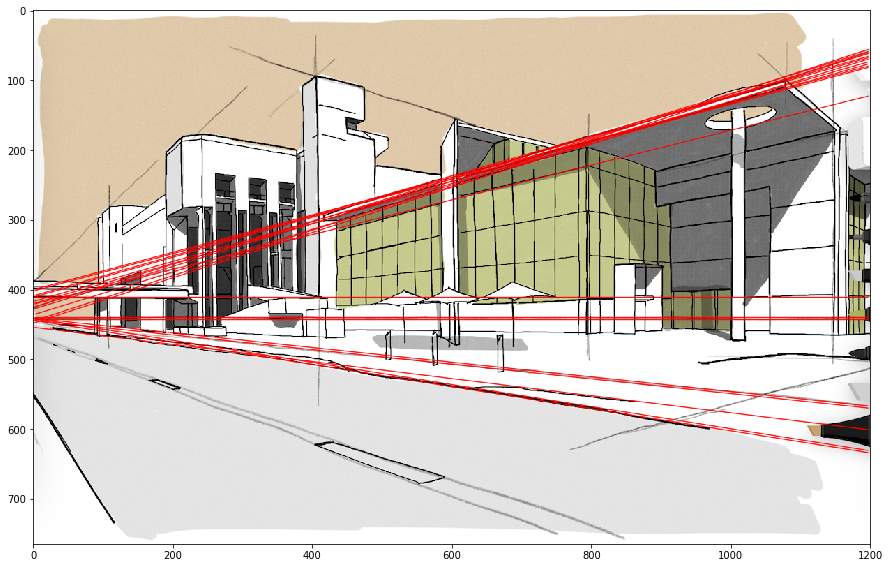

In [688]:
# Draw lines on a copy of the image
image_output = img.copy()

red = (255, 0, 0)

for rho, theta in lines[:,0,]:
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv2.line(image_output, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)
    
plt.figure(figsize=(15, 10))
plt.imshow(image_output)

# DIY Hough transform

In [771]:
# what resolution would we like our lines to be output
# the higher the resolution the prettier the Hough accumulator image will be!
distance_resolution = 2
angular_resolution = math.pi/180.0 / 6

height, width, _ = img.shape

# the maximum possible line length
max_rho = math.sqrt(width**2 + height**2)

# the number of linear steps (+/- max rho)
num_rho = int(2 * max_rho / distance_resolution) - 1
max_rho = num_rho * distance_resolution / 2

# the number of discrete angular steps
num_theta = int(math.pi / angular_resolution)

# we make a blank "accumulator" 2d array
# each point = one line
accumulator = np.zeros((num_rho, num_theta))
accumulator.shape

In [657]:
# loop through each point in the image
# this is not an efficient method :)
for x in range(0, width):
    for y in range(0, height):
        
        # get edge colour - will be either 0 (black), or 255 (white)
        edge_colour = edges[y, x]
        
        # if there's an edge
        if edge_colour != 0:
            
            # loop through each of the discrete values of theta
            # (based on our angular resolution - from 0 to pi radians)
            for theta in np.arange(0, math.pi, angular_resolution):

                # solve for the corresponding rho using the line equation
                rho = x * np.cos(theta) + y * np.sin(theta)

                # we then round each of the allowed discrete values of rho 
                # This will give us a locus of points lying approximately on a sinusoidal
                # curve for each edge point (x, y)

                rho_index = int(round(rho/distance_resolution + num_rho/2))
                theta_index = int(round(theta/angular_resolution))
                
                # increment by one each of the points in our accumulator matrix
                # that make up this sinusoidal curve
                accumulator[rho_index, theta_index] += 1


Text(0,0.5,'rho')

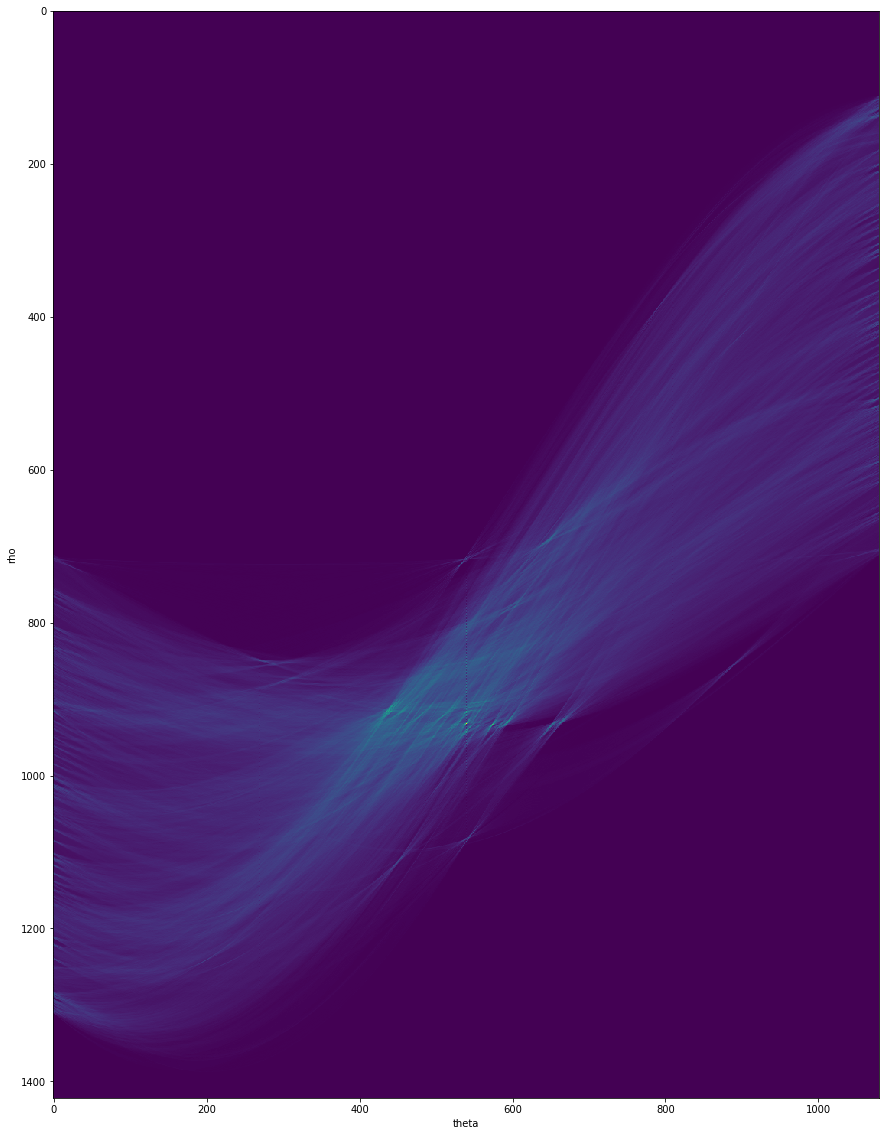

In [681]:
# Preview accumulator
# isn't it beautiful?
plt.figure(figsize=(20, 20))
plt.imshow(accumulator, cmap='viridis')
plt.xlabel('theta')
plt.ylabel('rho')

Text(0,0.5,'rho')

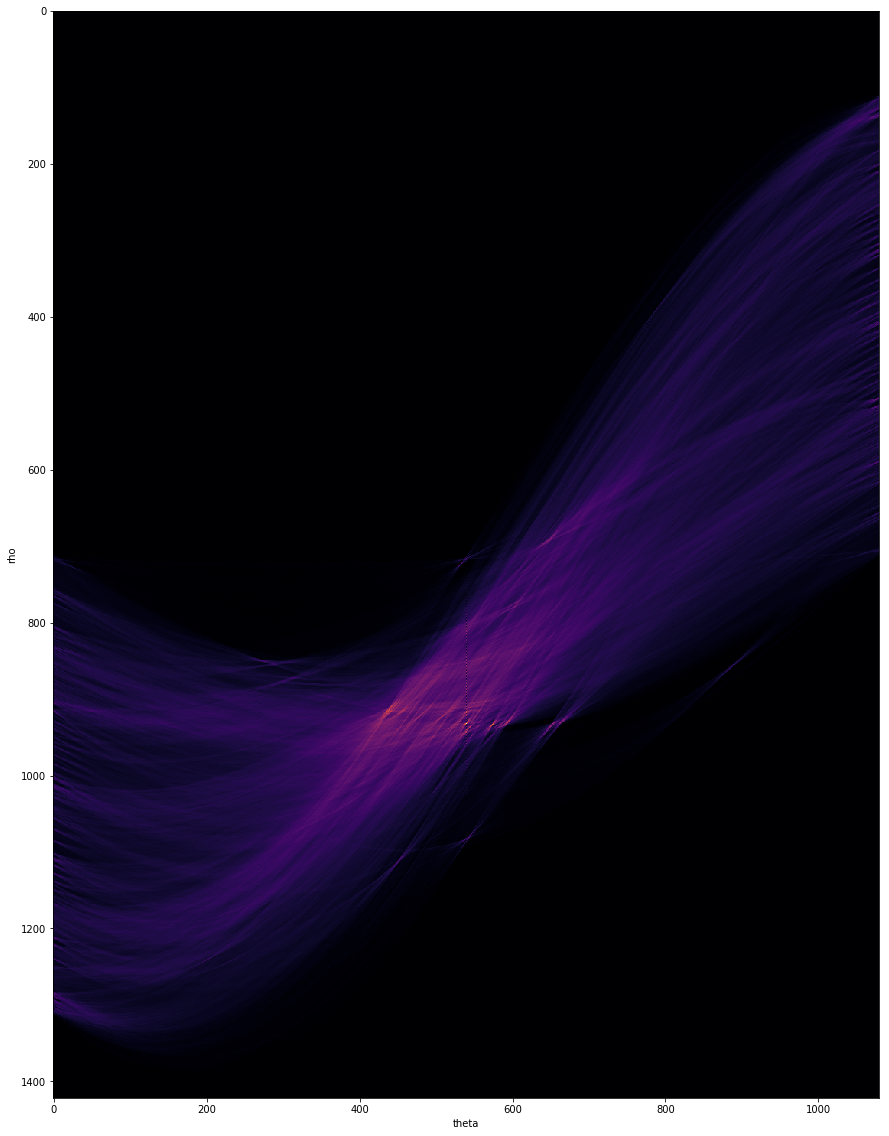

In [683]:
# Preview accumulator
plt.figure(figsize=(20, 20))
plt.imshow(accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')

### Let's investgate the max point

In [659]:
# Find the rho/theta coordinate of the max point
# this will be the strongest line in our image
max_rho_index, max_theta_index = np.unravel_index(accumulator.argmax(axis=None), accumulator.shape)
(max_rho_index, max_theta_index)


(932, 540)

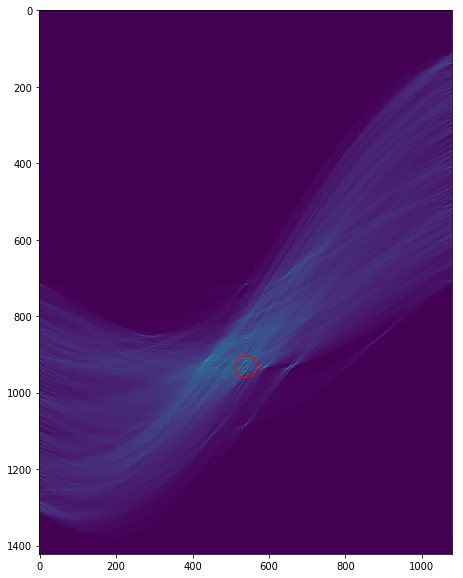

In [660]:
# circle the max point
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='viridis')
_ = plt.scatter(max_theta_index, max_rho_index, 500, color='r', facecolors='none', marker='o')

In [661]:
# convert index to actual rho/theta
max_rho_val = (max_rho_index - num_rho/2) * distance_resolution
max_theta_val = max_theta_index * angular_resolution
max_rho_val, max_theta_val

(442.0, 1.5707963267948966)

In [664]:
# convert from polar coordinates to x/y coordinates
(x1, y1), (x2, y2) = polar_to_xy(max_rho_val, max_theta_val)
(x1, y1), (x2, y2)

((0, 442), (1200, 441))

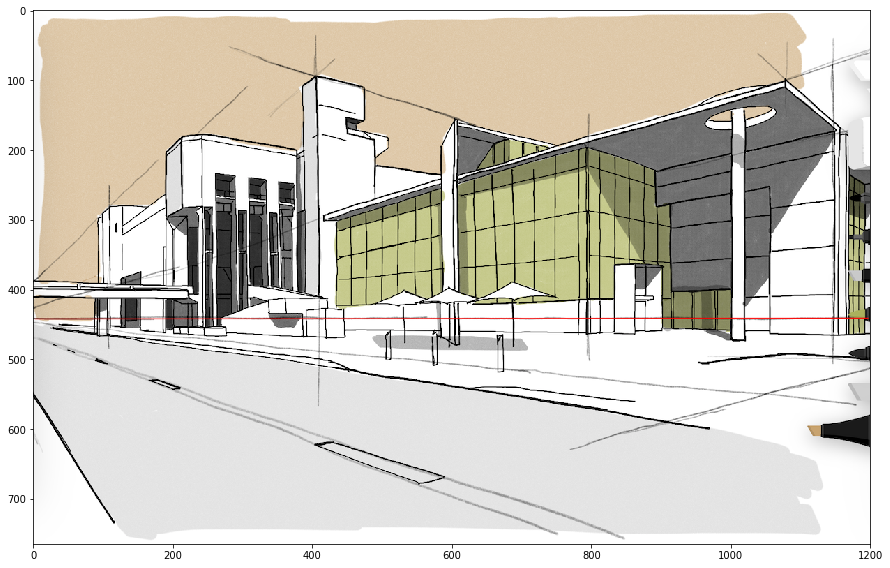

In [665]:
# draw line on image
max_line_img = img.copy()
cv2.line(max_line_img, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)
plt.figure(figsize=(15, 10))
plt.imshow(max_line_img)

### Thresholding accumulator image and filtering features

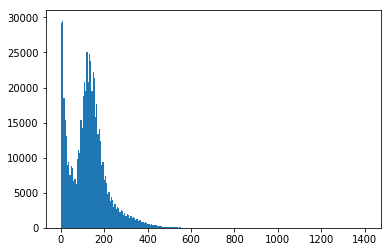

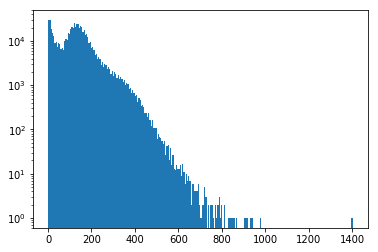

In [713]:
# Plot histogram of accumulator, to see what threshold is appropriate
flat = accumulator.flatten()
plt.figure()
plt.hist(flat[flat > 0], bins=250)
plt.figure()
plt.hist(flat[flat > 0], bins=250, log=True)
None

(650, 1000)

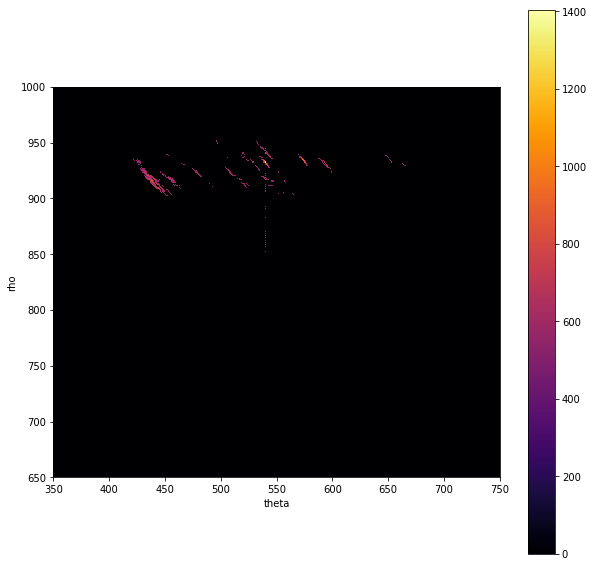

In [784]:
threshold = 550
thresholded_accumulator = accumulator.copy()
thresholded_accumulator[thresholded_accumulator <= threshold ] = 0 # np.nan

# Preview thresholded accumulator 
plt.figure(figsize=(10, 10))
plt.imshow(thresholded_accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')
plt.colorbar()

# zoom in a bit (manually)
plt.xlim(350, 750)
plt.ylim(650, 1000)

In [785]:
# !pip3 install scikit-image

In [786]:
# Going to use a scikit-image function to detect local peaks
# https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max
from skimage.feature import peak_local_max

In [787]:
# peaks are separated by at least min_distance
min_distance = 7
coordinates = peak_local_max(thresholded_accumulator, min_distance=min_distance)
coordinates.shape

(25, 2)

In [788]:
# first five coordinates
coordinates[:5,:]

array([[949, 497],
       [942, 540],
       [938, 453],
       [936, 506],
       [933, 652]])

In [789]:
# circle the local peaks / maxima
plt.figure(figsize=(20, 20))
plt.imshow(accumulator, cmap='viridis')
_ = plt.scatter(coordinates[:,1], coordinates[:,0], 30, color='r', marker='.')

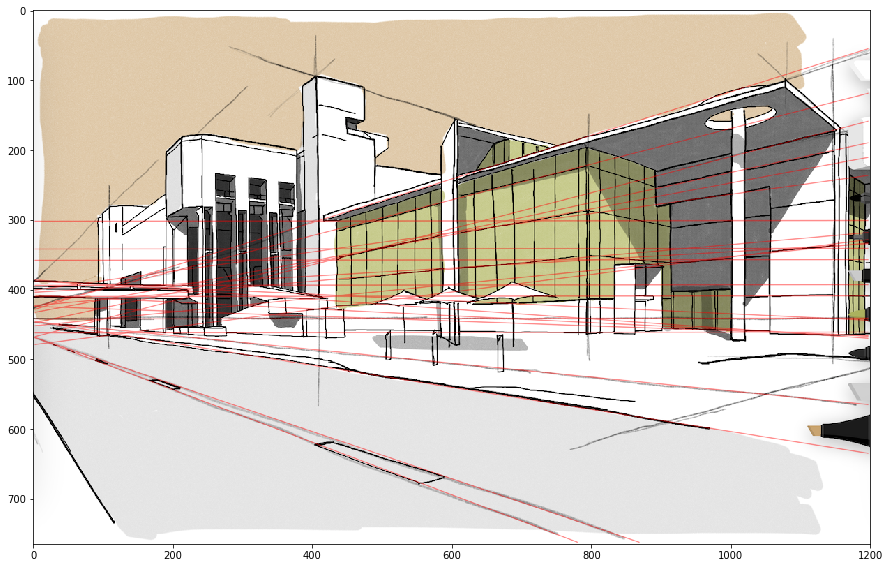

In [795]:
# Now convert all these points back to lines,
# and draw lines on a copy of the image
image_output = img.copy()

red = (255, 0, 0)

for rho_index, theta_index in coordinates:
    rho = (rho_index - num_rho/2) * distance_resolution
    theta = theta_index * angular_resolution
#     print((rho_index, theta_index), (rho, theta))
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv2.line(image_output, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)

# 50% "transparency" lines
image_output = cv2.addWeighted(img.copy(), 0.5, image_output, 0.5, 1)

plt.figure(figsize=(15, 10))
plt.imshow(image_output)